In [34]:
import pandas as pd

In [35]:
df = pd.read_parquet('../data/processed/wfp_preprocessed.parquet')
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,countryiso3,country,Value,Unit,standardprice
0,2014-01-15,None,None,National Average,NaN,NaN,cereals and tubers,Maize meal,KG,actual,Retail,SZL,8.94,0.8232,SWZ,Eswatini,1.0,1 KG,0.8232
1,2014-01-15,None,None,National Average,NaN,NaN,cereals and tubers,Rice,KG,actual,Retail,SZL,10.79,0.9936,SWZ,Eswatini,1.0,1 KG,0.9936
2,2014-01-15,None,None,National Average,NaN,NaN,cereals and tubers,Wheat flour,KG,actual,Retail,SZL,11.85,1.0912,SWZ,Eswatini,1.0,1 KG,1.0912
3,2014-01-15,None,None,National Average,NaN,NaN,miscellaneous food,Sugar (brown),KG,actual,Retail,SZL,10.21,0.9401,SWZ,Eswatini,1.0,1 KG,0.9401
4,2014-01-15,None,None,National Average,NaN,NaN,pulses and nuts,Beans (sugar),KG,actual,Retail,SZL,24.50,2.2560,SWZ,Eswatini,1.0,1 KG,2.2560


In [36]:
# Convert 'date' column to datetime (if it isn't already)
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # This handles any invalid dates

# Extract the year from the 'date' column and create a new 'year' column
df['year'] = df['date'].dt.year.astype(int)

df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,countryiso3,country,Value,Unit,standardprice,year
0,2014-01-15,None,None,National Average,NaN,NaN,cereals and tubers,Maize meal,KG,actual,Retail,SZL,8.94,0.8232,SWZ,Eswatini,1.0,1 KG,0.8232,2014
1,2014-01-15,None,None,National Average,NaN,NaN,cereals and tubers,Rice,KG,actual,Retail,SZL,10.79,0.9936,SWZ,Eswatini,1.0,1 KG,0.9936,2014
2,2014-01-15,None,None,National Average,NaN,NaN,cereals and tubers,Wheat flour,KG,actual,Retail,SZL,11.85,1.0912,SWZ,Eswatini,1.0,1 KG,1.0912,2014
3,2014-01-15,None,None,National Average,NaN,NaN,miscellaneous food,Sugar (brown),KG,actual,Retail,SZL,10.21,0.9401,SWZ,Eswatini,1.0,1 KG,0.9401,2014
4,2014-01-15,None,None,National Average,NaN,NaN,pulses and nuts,Beans (sugar),KG,actual,Retail,SZL,24.50,2.2560,SWZ,Eswatini,1.0,1 KG,2.2560,2014


In [65]:
nni = pd.read_csv('../data/raw/adjusted_net_national_income.csv')

# drop non-year columns
year_cols = [col for col in nni.columns if "[YR" in col] + ["Country Code"]
nni_filtered = nni[year_cols]

# melt the filtered DataFrame
nni_long = nni_filtered.melt(
    id_vars=["Country Code"],
    var_name="year",
    value_name="Adjusted NNI"
)

# clean up the 'year' column
nni_long['year'] = nni_long['year'].str.extract(r'(\d{4})')
nni_long['year'] = nni_long['year'].astype(int)

# drop rows where there's no NNI for that year
nni_long['Adjusted NNI'] = nni_long['Adjusted NNI'].replace('..', pd.NA)
nni_long = nni_long.dropna(subset=['Adjusted NNI'])

# chaneg type
nni_long['Adjusted NNI'] = nni_long['Adjusted NNI'].astype(float)

print(nni_long)

     Country Code  year  Adjusted NNI
0             AFG  2009    403.411183
1             ALB  2009   3517.609153
2             DZA  2009   2960.306317
5             AGO  2009   1870.287448
7             ARG  2009   6808.995877
...           ...   ...           ...
3453          SSF  2021   1286.741922
3454          SSA  2021   1285.834393
3455          TSS  2021   1286.741922
3456          UMC  2021   7136.672062
3457          WLD  2021   9707.192803

[2920 rows x 3 columns]


In [66]:
nni_long.dtypes

Country Code     object
year              int64
Adjusted NNI    float64
dtype: object

In [41]:
duplicates_nni = nni_long[nni_long.duplicated(subset=['Country Code', 'year'], keep=False)]
print(duplicates_nni)

Empty DataFrame
Columns: [Country Code, year, Adjusted NNI]
Index: []


In [ ]:
# # Perform the outer join on 'countryiso3' = 'Country Code' and 'year' = 'year'
# merged_df = pd.merge(
#     df, 
#     nni_long, 
#     how='left', 
#     left_on=['countryiso3', 'year'], 
#     right_on=['Country Code', 'year']
# )

# merged_df = merged_df.drop(columns=['Country Code'])
# print(len(df))

2293910


In [72]:
# Group by country and year, and calculate average standard price
avg_price = df.groupby(['country', 'countryiso3', 'year'])['standardprice'].mean().reset_index()
# print(avg_price)

# Perform the outer join on 'countryiso3' = 'Country Code' and 'year' = 'year'
affordability_df = pd.merge(
    avg_price, 
    nni_long, 
    how='left', 
    left_on=['countryiso3', 'year'], 
    right_on=['Country Code', 'year']
)

affordability_df = affordability_df.drop(columns=['Country Code'])
affordability_df = affordability_df.dropna()
print(affordability_df)

         country countryiso3  year  standardprice  Adjusted NNI
0    Afghanistan         AFG  2014       0.623119    575.916815
1    Afghanistan         AFG  2015       0.556338    548.968455
2    Afghanistan         AFG  2016       0.511449    484.890590
3    Afghanistan         AFG  2017       0.517257    497.406029
4    Afghanistan         AFG  2018       0.495619    466.570602
..           ...         ...   ...            ...           ...
936     Zimbabwe         ZWE  2017       1.177101    903.872575
937     Zimbabwe         ZWE  2018       1.392374   1982.943538
938     Zimbabwe         ZWE  2019       0.000613   1224.803942
939     Zimbabwe         ZWE  2020       0.002424   1171.848837
940     Zimbabwe         ZWE  2021       0.004162   1490.550309

[703 rows x 5 columns]


In [74]:
from sklearn.preprocessing import StandardScaler

# Standardize Adjusted NNI and average price within each country
scaler = StandardScaler()
affordability_df[['Adjusted NNI (scaled)', 'standardprice (scaled)']] = scaler.fit_transform(
    affordability_df[['Adjusted NNI', 'standardprice']]
)

# Compute the affordability index (higher is better)
affordability_df['affordability_index'] = 100 * (1 - affordability_df['standardprice (scaled)'] / affordability_df['Adjusted NNI (scaled)'])

# Clip the index to stay within 0–100
affordability_df['affordability_index'] = affordability_df['affordability_index'].clip(0, 100)

affordability_df.head()

,country,countryiso3,year,standardprice,Adjusted NNI,Adjusted NNI (scaled),standardprice (scaled),affordability_index
0,Afghanistan,AFG,2014,0.623119,575.916815,-0.616277,-0.123322,79.989155
1,Afghanistan,AFG,2015,0.556338,548.968455,-0.623431,-0.125361,79.891796
2,Afghanistan,AFG,2016,0.511449,484.890590,-0.640443,-0.126731,80.211956
3,Afghanistan,AFG,2017,0.517257,497.406029,-0.637120,-0.126554,80.136585
4,Afghanistan,AFG,2018,0.495619,466.570602,-0.645306,-0.127214,80.286209


<Axes: >

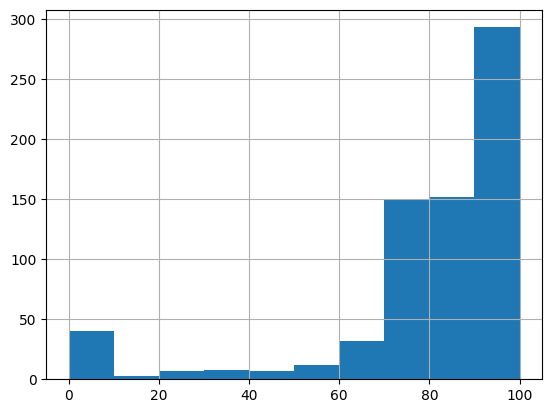

In [75]:
affordability_df['affordability_index'].hist()